In [1]:
import pyvista

pyvista.start_xvfb()
pyvista.set_jupyter_backend("client")

In [2]:
import jax

jax.config.update(
    "jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache-notebook"
)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np

import functools
from jax.typing import ArrayLike
from jax import Array

from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [4]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from pixel_refinement import downscale_binary_array, upscale_binary_array

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

## Stability analysis

In [5]:
def create_homogeneous_honeycomb(N, nb_rows=2):
    l = 9.97
    length = nb_rows * l

    H, L = (N, N)
    structure = np.zeros((H, L))

    dx = length / H
    dy = length / L

    # radius = length / 5
    radius = 8.67 / 2
    r_pixel = int(radius / dx)

    for i in range(0, nb_rows):
        for j in range(0, nb_rows):
            center = l / 2.0
            Hmid = int((center + l * i) / dx)
            Lmid = int((center + l * j) / dy)
            structure[
                Hmid - r_pixel : Hmid + 1 + r_pixel, Lmid - r_pixel : Lmid + 1 + r_pixel
            ] += disk(r_pixel)

    return structure, length, N


def create_phononic_band_structure(NN):
    N = 3 * NN
    nb_rows = 3

    l = 9.97
    length = nb_rows * l

    H, L = (N, N)
    structure = np.zeros((H, L))

    dx = length / H
    dy = length / L

    # radius = length / 5
    radius = 8.67 / 2
    r_pixel = int(radius / dx)

    for i in range(0, nb_rows):
        for j in range(0, nb_rows):
            center = l / 2.0
            Hmid = int((center + l * i) / dx)
            Lmid = int((center + l * j) / dy)
            structure[
                Hmid - r_pixel : Hmid + 1 + r_pixel, Lmid - r_pixel : Lmid + 1 + r_pixel
            ] += disk(r_pixel)

    Hmid = int(N / 2)
    Lmid = int(N / 2)
    structure = structure[
        Hmid - int(NN) : Hmid + 1 + int(NN), Lmid - int(NN) : Lmid + 1 + int(NN)
    ]

    return structure, dx * structure.shape[0], structure.shape[0]


def create_circular_honeycomb():
    length = 1
    structure = np.load("./figs/blurred_lattice.npy")
    structure = np.where(structure < 0.6, 0, 1)
    H, L = structure.shape
    size = np.minimum(H, L)
    if size % 2 == 0:
        size = size - 1
    structure = structure[:size, :size]

    return structure, length, structure.shape[0]

In [6]:
differential_operator = "rotated"
structure, length, N = create_phononic_band_structure(NN=49)

dx = dy = length / N

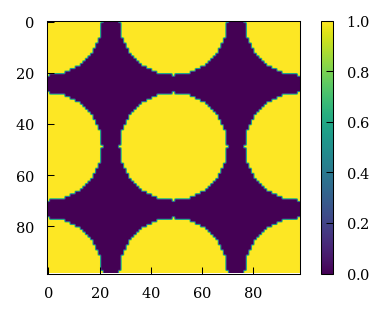

In [7]:
plt.imshow(structure)
plt.colorbar()

In [8]:
np.sum(1 - structure) / structure.shape[0] / structure.shape[0]

0.4219977553310887

In [9]:
ndim = len(structure.shape)
N = structure.shape[0]

In [10]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor

In [11]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    X = upscale_binary_array(X)
    properties = soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)
    return downscale_binary_array(properties)

In [12]:
# material parameters
phase_contrast = 1e-3
E = 1
ν = 0.3

elastic_modulus = {"hard": E, "soft": E * phase_contrast}  # N/mm2
poisson_modulus = {"hard": ν, "soft": ν}

# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3


c1_modulus = {"hard": 0.55, "soft": 0.55 * phase_contrast}
c2_modulus = {"hard": 0.3, "soft": 0.3 * phase_contrast}
bulk_modulus = {"hard": 55, "soft": 55 * phase_contrast}


# material parameters
K = param(
    structure, soft=bulk_modulus["soft"], hard=bulk_modulus["hard"]
)  # bulk      modulus

c1 = param(
    structure, soft=c1_modulus["soft"], hard=c1_modulus["hard"]
)  # bulk      modulus

c2 = param(
    structure, soft=c2_modulus["soft"], hard=c2_modulus["hard"]
)  # bulk      modulus


μ0 = param(
    structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
)  # shear     modulus
λ0 = param(
    structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
)  # shear     modulus

In [13]:
# determinant of grid of 2nd-order tensors
@jax.jit
def det2(A2):
    return jnp.multiply(A2.at[0, 0].get(), A2.at[1, 1].get()) - jnp.multiply(
        A2.at[0, 1].get(), A2.at[1, 0].get()
    )


@jax.jit
def green_lagrange_strain(F: ArrayLike) -> Array:
    return 0.5 * (tensor.dot22(tensor.trans2(F), F) - I)


@jax.jit
def right_cauchy_green_tensor(F: ArrayLike) -> Array:
    return tensor.dot22(tensor.trans2(F), F)


@jax.jit
def st_venant_strain_energy(F: ArrayLike) -> Array:
    E = green_lagrange_strain(F)
    E = 0.5 * (E + tensor.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(E, E))
    )
    return energy.sum()


@jax.jit
def mooney_rivlin_strain_energy(F: ArrayLike) -> Array:
    C = right_cauchy_green_tensor(F)
    J = det2(F)
    I1 = tensor.trace2(C)

    energy = (
        jnp.multiply(c1, I1 - 2)
        + jnp.multiply(c2, jnp.multiply(I1 - 2, I1 - 2))
        - jnp.multiply(2 * c1, jnp.log(J))
        + jnp.multiply(0.5 * K, jnp.multiply(J - 1, J - 1))
    )
    return energy.sum()


piola_kirchhoff = jax.jit(jax.jacrev(mooney_rivlin_strain_energy))

In [14]:
Ghat4_2 = compute_Ghat_4_2(
    NN=(N,) * ndim, operator=differential_operator, length=length
)

In [15]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

In [16]:
# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)


@functools.partial(jax.jit, static_argnames=["piola_kirchhoff"])
def G_P(dF, additional, piola_kirchhoff):
    dF = dF.reshape(ndim, ndim, N, N)
    tangents = jax.jvp(piola_kirchhoff, (additional,), (dF,))[1]
    return G(tangents)

In [17]:
@functools.partial(jax.jit, static_argnames=["A", "K"])
def conjugate_gradient(A, b, additional, K, atol=1e-5):
    b, additional = jax.device_put((b, additional))
    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p, additional, K)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter += 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)
    p = r
    rsold = jnp.vdot(r, r)
    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter

In [18]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn, iiter = state

    error = jnp.linalg.norm(dF) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        dF, b, F, Fn, iiter = state

        dF, iiter_cg = conjugate_gradient(
            atol=1e-8,
            A=G_P,
            b=b,
            additional=F,
            K=piola_kirchhoff,
        )  # solve linear system using CG

        dF = dF.reshape(ndim, ndim, N, N)
        F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
        P = piola_kirchhoff(F)  # new residual stress
        b = -G(P)  # convert residual stress to residual
        iiter = iiter.at[n, 0].set(iiter_cg)
        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    def false_fun(state):
        dF, b, F, Fn, iiter = state

        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    return jax.lax.cond(error > 1e-6, true_fun, false_fun, state), n

In [ ]:
ninc = 200
Δε = -0.1 / float(ninc)  # total strain / number of increments
ε = 0.0  # strain

# set macroscopic loading
barF = jnp.array(I, copy=True)
barF_t = jnp.array(I, copy=True)

# microscopic deformation gradient
F = jnp.array(I, copy=True)
F_t = jnp.array(I, copy=True)


macro_sigs = []

for i in tqdm(range(ninc)):
    print(i)

    ε += Δε

    barF = jnp.array(I, copy=True)
    barF = barF.at[1, 1].set(
        1 + ε
    )  # one is added to convert strain to total deformation

    Fn = jnp.linalg.norm(F)

    DbarF = barF - barF_t

    # first iteration residual: distribute "DbarF" over grid using "push-forward-approach"
    b = -G_P(DbarF, F, piola_kirchhoff)
    F = jax.lax.add(F, DbarF)

    Fn = jnp.linalg.norm(F)

    iiter = jnp.zeros((10, 2))
    state = (DbarF, b, F, Fn, iiter)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        solve_netwon_raphson, init=initial_state, xs=jnp.arange(0, 10)
    )

    # end-of-increment: update history
    barF_t = jnp.array(barF, copy=True)

    F = jnp.array(final_state[2], copy=True)
    F_t = jnp.array(final_state[2], copy=True)

    𝐏 = piola_kirchhoff(F_t)

    macro_sigma = jnp.array(
        [
            jnp.sum(𝐏.at[0, 0].get() * dx * dy),
            jnp.sum(𝐏.at[1, 1].get() * dx * dy),
            0.5
            * (
                jnp.sum(𝐏.at[1, 0].get() * dx * dy)
                + jnp.sum(𝐏.at[0, 1].get() * dx * dy)
            ),
        ]
    )
    macro_sigma = macro_sigma / length**2
    macro_sigs.append(
        [macro_sigma.at[0].get(), macro_sigma.at[1].get(), macro_sigma.at[2].get()]
    )

  0%|          | 0/200 [00:00<?, ?it/s]

0
residual=0.0003536417899866619
residual=0.0004220245345594248
residual=1.0324235430391251e-05
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
residual=1.3572134021223339e-09
1
residual=0.0003537301806723161
residual=0.0004227426964509392
residual=1.0370314061056598e-05
residual=1.380266594377876e-09
residual=1.380266594377876e-09
residual=1.380266594377876e-09
residual=1.380266594377876e-09
residual=1.380266594377876e-09
residual=1.380266594377876e-09
residual=1.380266594377876e-09
2
residual=0.00035381853158265533
residual=0.00042346431308379324
residual=1.0419851129843248e-05
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
residual=1.3778937305980786e-09
3
residual=0.0003539068423057327
residual=0.0

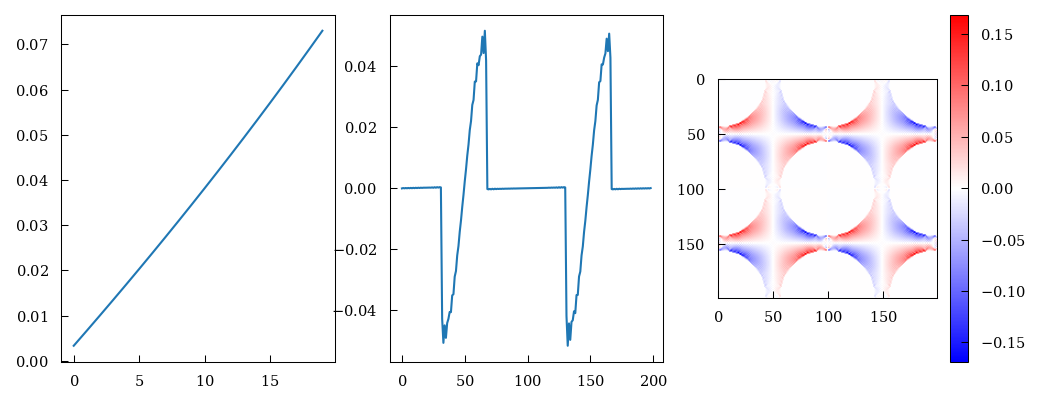

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
# axes[0].plot(np.asarray(macro_sigs)[:, 0])
axes[0].plot(np.abs(np.asarray(macro_sigs)[:, 1]))

stress = piola_kirchhoff(F_t)
E = green_lagrange_strain(F_t)
E_ddot_E = jnp.sqrt((1 - structure) * tensor.ddot22(E, E))

axes[1].plot(stress.at[0, 1].get()[70, :])

im = axes[2].imshow(stress.at[0, 1].get(), cmap="bwr")
plt.colorbar(im)
plt.show()

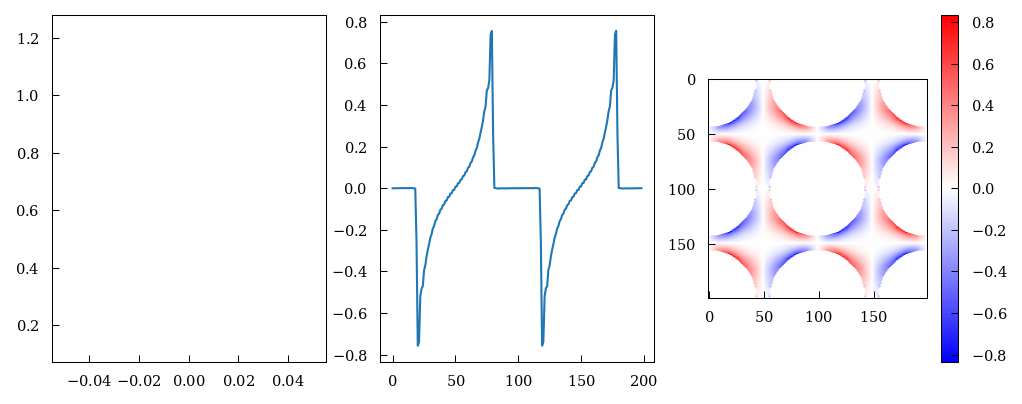

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].plot(np.asarray(macro_sigs)[:, 0])
axes[0].plot(np.asarray(macro_sigs)[:, 1])

stress = piola_kirchhoff(F_t)
E = green_lagrange_strain(F_t)
E_ddot_E = jnp.sqrt((1 - structure) * tensor.ddot22(E, E))

axes[1].plot(stress.at[0, 1].get()[39, :])

im = axes[2].imshow(stress.at[0, 1].get(), cmap="bwr")
plt.colorbar(im)
plt.show()

In [24]:
np.asarray(macro_sigs)

array([[ 9.76715922e-02,  8.48748821e-01, -3.12387515e-15],
       [ 9.76867786e-02,  8.48915576e-01, -1.23246781e-15],
       [ 9.77019651e-02,  8.49082351e-01,  2.33158761e-15],
       [ 9.77171518e-02,  8.49249146e-01,  4.04667190e-16],
       [ 9.77323387e-02,  8.49415962e-01, -2.93190577e-16],
       [ 9.77475256e-02,  8.49582798e-01,  1.19066165e-15],
       [ 9.77627127e-02,  8.49749655e-01,  1.21576435e-15],
       [ 9.77778999e-02,  8.49916532e-01, -2.80840934e-15],
       [ 9.77930873e-02,  8.50083429e-01,  1.02540117e-15]])

In [79]:
x = np.linspace(-length / 2, length / 2, structure.shape[0])
y = np.linspace(-length / 2, length / 2, structure.shape[1])
xx, yy = np.meshgrid(x, y)

In [80]:
points = np.c_[xx.reshape(-1), yy.reshape(-1), np.zeros(N * N).reshape(-1)]
cloud = pyvista.PolyData(points)
surf = cloud.delaunay_2d()

In [81]:
strain = F_t - I
eps_xx = np.asarray(strain.at[0, 0].get()).reshape(-1)
eps_xy = np.asarray(strain.at[0, 1].get()).reshape(-1)
eps_yy = np.asarray(strain.at[1, 1].get()).reshape(-1)

In [82]:
surf.point_data["eps_xx"] = eps_xx
surf.point_data["phase"] = 1 - structure.reshape(-1)

In [83]:
u_3D = np.zeros((N * N, 3))
u_3D[:, 0] = surf.points[:, 0] * eps_xx * (1 - structure).reshape(-1) + surf.points[
    :, 1
] * eps_xy * (1 - structure).reshape(-1)
u_3D[:, 1] = surf.points[:, 0] * eps_xy * (1 - structure).reshape(-1) + surf.points[
    :, 1
] * eps_yy * (1 - structure).reshape(-1)

In [84]:
surf.point_data["Displacement"] = u_3D
surf.set_active_vectors("Displacement")

In [85]:
threshold = surf.threshold(value=0.02, continuous=False, scalars="phase")
plotter = pyvista.Plotter()
plotter.window_size = (900, 400)
plotter.add_mesh(threshold, scalars="Displacement")
edges = threshold.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.0)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/45207/index.html?ui=P_0x148452588a90_3&reconnect=auto" class="p…

In [86]:
surf_2 = threshold.extract_geometry()
threshold_2 = surf_2.smooth(
    boundary_smoothing=True,
    feature_smoothing=False,
    n_iter=20,
    relaxation_factor=0.05,
    edge_angle=120,
)

In [87]:
plotter = pyvista.Plotter()
plotter.window_size = (900, 400)
plotter.add_mesh(threshold_2, scalars="eps_xx", cmap="magma_r")

edges = threshold_2.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.0)
plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/45207/index.html?ui=P_0x14844b892e90_4&reconnect=auto" class="p…

In [89]:
warped = threshold_2.warp_by_vector("Displacement", factor=1)
plotter = pyvista.Plotter()
plotter.window_size = (800, 400)
plotter.add_mesh(warped, scalars="Displacement", cmap="Spectral")

edges = warped.extract_all_edges()
plotter.add_mesh(edges, color="k", line_width=1, opacity=0.1)
plotter.view_xy()

plotter.view_xy()

plotter.show()

Widget(value='<iframe src="/user/mpundir/proxy/45207/index.html?ui=P_0x14844e590bd0_5&reconnect=auto" class="p…

In [10]:
def use_ad_fft_method(structure, loading):
    N = structure.shape[0]
    ndim = len(structure.shape)

    # identity tensor (single tensor)
    i = jnp.eye(ndim)

    # identity tensors (grid)
    I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor
    I4 = jnp.einsum(
        "ijkl,xy->ijklxy", jnp.einsum("il,jk", i, i), jnp.ones([N, N])
    )  # 4th order Identity tensor
    I4rt = jnp.einsum("ijkl,xy->ijklxy", jnp.einsum("ik,jl", i, i), jnp.ones([N, N]))
    I4s = (I4 + I4rt) / 2.0

    II = tensor.dyad22(I, I)

    # material parameters
    elastic_modulus = {"hard": 5.7, "soft": 0.57}  # N/mm2
    poisson_modulus = {"hard": 0.386, "soft": 0.386}
    jm_modulus = {"hard": 0.2, "soft": 0.4}

    # lames constant
    lambda_modulus = {}
    shear_modulus = {}
    bulk_modulus = {}

    for key in elastic_modulus.keys():
        lambda_modulus[key] = (
            poisson_modulus[key]
            * elastic_modulus[key]
            / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
        )

        shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

        bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

    # material parameters
    K = param(
        structure, soft=bulk_modulus["soft"], hard=bulk_modulus["hard"]
    )  # bulk      modulus
    μ0 = param(
        structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
    )  # shear     modulus
    λ0 = param(
        structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
    )  # shear     modulus

    Jm = param(
        structure, soft=jm_modulus["soft"], hard=jm_modulus["hard"]
    )  # shear     modulus

    Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

    # (inverse) Fourier transform (for each tensor component in each direction)
    @jax.jit
    def fft(x):
        return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))

    @jax.jit
    def ifft(x):
        return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

    # functions for the projection 'G', and the product 'G : K : dF'
    @jax.jit
    def G(A2):
        return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)

    @jax.jit
    def green_lagrange_strain(F: ArrayLike) -> Array:
        return 0.5 * (tensor.dot22(tensor.trans2(F), F) - I)

    @jax.jit
    def strain_energy(F: ArrayLike) -> Array:
        E = green_lagrange_strain(F)
        E = 0.5 * (E + tensor.trans2(E))
        energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E) ** 2) + jnp.multiply(
            μ0, tensor.trace2(tensor.dot22(E, E))
        )
        return energy.sum()

    # determinant of grid of 2nd-order tensors
    """@jax.jit
    def det2(A2):
        return (
            A2.at[0, 0].get() * A2.at[1, 1].get()
            - A2.at[0, 1].get() * A2.at[1, 0].get()
        )

    @jax.jit
    def left_cauchy_green_deformation_tensor(F: ArrayLike) -> Array:
        return tensor.dot22(tensor.trans2(F), F)

    @jax.jit
    def strain_energy(F: ArrayLike) -> Array:
        B = left_cauchy_green_deformation_tensor(F)
        J = det2(F)
        I1 = tensor.trace2(B)
        energy = -jnp.multiply(
            μ0 / 2.0,
            jnp.multiply(Jm, jnp.log(1 - jnp.divide(I1 - 3, Jm)) + 2 * jnp.log(J)),
        )
        return energy.sum()"""

    piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

    @functools.partial(jax.jit, static_argnames=["piola_kirchhoff"])
    def G_P(dF, additional, piola_kirchhoff):
        dF = dF.reshape(ndim, ndim, N, N)
        tangents = jax.jvp(piola_kirchhoff, (additional,), (dF,))[1]
        return G(tangents)

    @functools.partial(jax.jit, static_argnames=["A", "K"])
    def conjugate_gradient(A, b, additional, K, atol=1e-5):
        b, additional = jax.device_put((b, additional))
        iiter = 0

        def body_fun(state):
            b, p, r, rsold, x, iiter = state
            Ap = A(p, additional, K)
            alpha = rsold / jnp.vdot(p, Ap)
            x = x + jnp.dot(alpha, p)
            r = r - jnp.dot(alpha, Ap)
            rsnew = jnp.vdot(r, r)
            p = r + (rsnew / rsold) * p
            rsold = rsnew
            iiter += 1
            return (b, p, r, rsold, x, iiter)

        def cond_fun(state):
            b, p, r, rsold, x, iiter = state
            return jnp.sqrt(rsold) > atol

        x = jnp.zeros_like(b)
        r = b - A(x, additional, K)
        p = r
        rsold = jnp.vdot(r, r)
        b, p, r, rsold, x, iiter = jax.lax.while_loop(
            cond_fun, body_fun, (b, p, r, rsold, x, iiter)
        )
        return x, iiter

    @jax.jit
    def solve_netwon_raphson(state, n):
        dF, b, F, Fn, iiter = state

        error = jnp.linalg.norm(dF) / Fn
        jax.debug.print("residual={}", error)

        def true_fun(state):
            dF, b, F, Fn, iiter = state

            dF, iiter_cg = conjugate_gradient(
                atol=1e-8,
                A=G_P,
                b=b,
                additional=F,
                K=piola_kirchhoff,
            )  # solve linear system using CG

            dF = dF.reshape(ndim, ndim, N, N)
            F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
            P = piola_kirchhoff(F)  # new residual stress
            b = -G(P)  # convert residual stress to residual
            iiter = iiter.at[n, 0].set(iiter_cg)
            iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)
            energy = strain_energy(F)
            jax.debug.print("energy={}", energy)

            return (dF, b, F, Fn, iiter)

        def false_fun(state):
            dF, b, F, Fn, iiter = state

            iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

            return (dF, b, F, Fn, iiter)

        return jax.lax.cond(error > 1e-6, true_fun, false_fun, state), n

    # set macroscopic loading
    DbarF = jnp.zeros([ndim, ndim, N, N])
    DbarF = DbarF.at[0, 1].add(loading)

    # initial residual: distribute "barF" over grid using "K"
    F = jnp.array(I, copy=True)
    b = -G_P(DbarF, F, piola_kirchhoff)
    F = jax.lax.add(F, DbarF)
    Fn = jnp.linalg.norm(F)

    iiter = jnp.zeros((10, 2))
    state = (DbarF, b, F, Fn, iiter)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(
        solve_netwon_raphson, init=initial_state, xs=jnp.arange(0, 10)
    )

    return strain_energy(final_state[2])

In [12]:
structure = setup(127)
loading = 0.1
energies.append(use_ad_fft_method(structure, loading))

residual=0.0705345615858598
energy=127.46626324007637
residual=0.04246815496953467
energy=126.74792420955737
residual=0.00371559999806758
energy=126.74767971054932
residual=0.0001068818661015296
energy=126.7476797028442
residual=7.97473308396103e-07
residual=7.97473308396103e-07
residual=7.97473308396103e-07
residual=7.97473308396103e-07
residual=7.97473308396103e-07
residual=7.97473308396103e-07


In [8]:
loadings = np.linspace(0.05, 0.2, num=6)
energies = []
for loading in tqdm(loadings):
    energies.append(use_ad_fft_method(structure, loading))

  0%|          | 0/6 [00:00<?, ?it/s]

residual=0.035333262666878584
residual=0.021872763921201605
residual=0.0009502266983946121
residual=6.021549244214551e-06
residual=1.5373427356757649e-09
residual=1.5373427356757649e-09
residual=1.5373427356757649e-09
residual=1.5373427356757649e-09
residual=1.5373427356757649e-09
residual=1.5373427356757649e-09
residual=0.05647824947249056
residual=0.034457866611107085
residual=0.002403589006957217
residual=4.1856931391419326e-05
residual=1.027049990562068e-07
residual=1.027049990562068e-07
residual=1.027049990562068e-07
residual=1.027049990562068e-07
residual=1.027049990562068e-07
residual=1.027049990562068e-07
residual=0.07754751842218242
residual=0.046335405828044046
residual=0.004468651396575697
residual=0.0001600065382950508
residual=1.9275784676456656e-06
residual=4.022866538011794e-10
residual=4.022866538011794e-10
residual=4.022866538011794e-10
residual=4.022866538011794e-10
residual=4.022866538011794e-10
residual=0.09851341054817477
residual=0.05730633313456716
residual=0.007

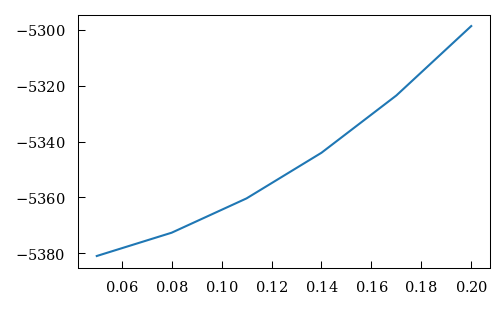

In [9]:
plt.plot(loadings, energies)